In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas
import json
import ot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import random
import tqdm
from tqdm import tqdm
import seaborn as sb
import scipy as sp
import topo_util
from topo_util import noisy_circle
import sklearn as sk
import sklearn.decomposition
import math
import pd

cmap = "hsv"

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def loop(n_loops, radius, n_samples, noise, reflect = False):
    t = np.linspace(0,2*np.pi,2*n_loops +1)
    x = radius*np.cos(t)
    y = radius*np.sin(t)
    rad = radius*np.pi/n_loops
    data = noisy_circle(n_samples, noise, x[0], y[0], rad)
    for j in range(2,len(t)-4,2):
        data = np.concatenate([data, noisy_circle(n_samples, noise, x[j], y[j], rad)])
    if reflect:
        data = np.array([[-el[0], -el[1]] for el in data])
    return data    

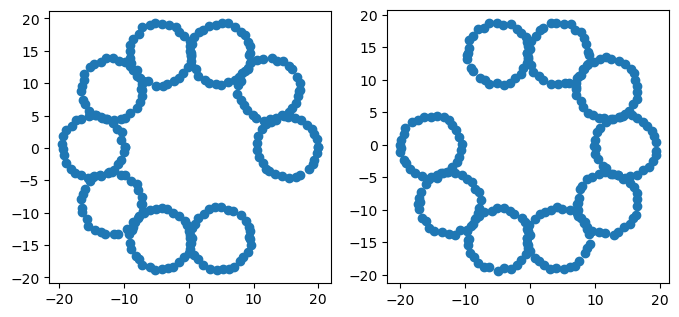

In [3]:
plt.subplot(1, 2, 1)
A = loop(10, 15, 30, 0.1)
plt.scatter(A[:,0],A[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.subplot(1, 2, 2)
B = loop(10, 15, 30, 0.1, True)
plt.scatter(B[:,0],B[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [4]:
def PH(X):
    df = pandas.DataFrame()
    for ii in range(X.shape[1]):
        df['x_{}'.format(ii)] =  X[:,ii]
    df.to_csv("pointcloud.tsv", sep = '\t', index = False)
    !julia ../src/PH.jl 
    with open('PH.json','r') as f:
        dic = json.load(f)
    return dic 

In [5]:
H_all = [PH(x) for x in tqdm([A,B])]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:22<00:00, 11.09s/it]


In [6]:
df1 = topo_util.make_dataframe(H_all[0]["barcode"])
df2 = topo_util.make_dataframe(H_all[1]["barcode"])

In [7]:
import ot
p_spt = df1.iloc[:, 0:2].to_numpy()
q_spt = df2.iloc[:, 0:2].to_numpy()
p, q = pd.augmented_weights(p_spt, q_spt)
C = pd.augmented_cost(p_spt, q_spt)
pi = ot.emd(p, q, C)

In [8]:
import matplotlib.pyplot as plt
import importlib
import numpy as np
from tqdm import tqdm
import hypernetx as hnx
import tpot

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [9]:
G_all = [hnx.Hypergraph({str(i) : k for (i, k) in enumerate(g['representatives'])}) for g in H_all]

In [10]:
y0, w0, v0 = topo_util.process_hg(G_all[0], A.shape[0])
y1, w1, v1 = topo_util.process_hg(G_all[1], B.shape[0])

In [11]:
# similarity with kernel
h = 0.25
K0 = topo_util.get_kernel(A, h)
L0 = topo_util.symmetric_laplacian(K0)
K0 /= K0.sum(-1).reshape(-1, 1)
K1 = topo_util.get_kernel(B, h)
L1 = topo_util.symmetric_laplacian(K1)
K1 /= K1.sum(-1).reshape(-1, 1)

In [12]:
y0_imputed = topo_util.impute_laplacian(y0, L0)
y1_imputed = topo_util.impute_laplacian(y1, L1)

In [13]:
y0 = y0_imputed; y1 = y1_imputed;

In [14]:
C_v0 = sp.spatial.distance.cdist(A, A, metric = "euclidean"); C_v0 /= np.mean(C_v0)
C_v1 = sp.spatial.distance.cdist(B, B, metric = "euclidean"); C_v1 /= np.mean(C_v1)
C_pd = pd.augmented_cost(p_spt, q_spt)

In [15]:
alpha = 0.9
beta = 5
v0 = p
v1 = q
pi_s, pi_f, _, = tpot.TPOT(y0, y1, w0, w1, v0, v1,
                          C_v0, C_v1, C_pd, 
                          alpha = alpha, beta = beta, print_iter = 5, iter = 50, 
                          eps_s = 0.01, eps_f = 0.01,
                          solver = "sinkhorn")

Iteration 0,	 obj = 0.322397439277437,	 obj_terms = {'coot': 0.13308438422221797, 'ot': 0.0007331010031048025, 'gw': 0.18857995405211422}
Iteration 5,	 obj = 0.09582439751778059,	 obj_terms = {'coot': 0.030177042159610035, 'ot': 0.000575787454728181, 'gw': 0.06507156790344237}
Iteration 10,	 obj = 0.0712434987340729,	 obj_terms = {'coot': 0.01898749678750726, 'ot': 0.0005751882616750516, 'gw': 0.05168081368489059}
Iteration 15,	 obj = 0.07122965627065579,	 obj_terms = {'coot': 0.019000406147219207, 'ot': 0.0005751882598081077, 'gw': 0.051654061863628475}
is_converged, obj = 0.07122950103613611, obj_new = 0.07122950007695802


In [16]:
sizes_p = 40 + np.zeros((len(p_spt)))
sizes_q = 40 + np.zeros((len(q_spt)))
sizes_p[-1] = 100
sizes_q[-1] = 100

color_p = 1+ np.zeros((len(p_spt)))
color_q =  1+np.ones((len(q_spt)))
# plt.figure(figsize = (5, 5))
# pd.plot_pd(p, q, p_spt, q_spt, pi, color_p, color_q, sizes_p, sizes_q)
# plt.savefig('outputs/ex3_diagrams.png', dpi=300)

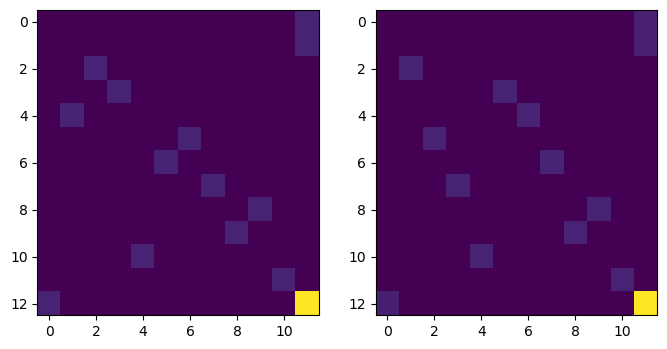

In [17]:
plt.subplot(1, 2, 1)
plt.imshow(pi)
plt.subplot(1, 2, 2)
plt.imshow(pi_f)

Text(0.5, 1.0, 'Geometric cycle matching')

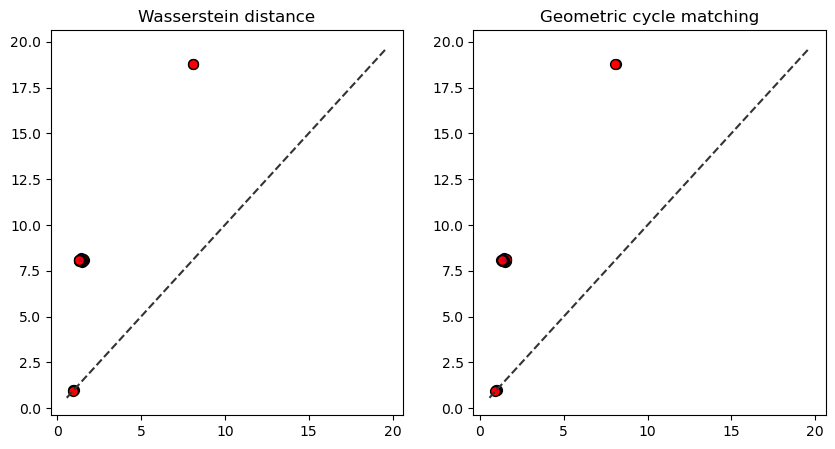

In [18]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
pd.plot_pd_connections(p, q, p_spt, q_spt, pi)
plt.title("Wasserstein distance")
plt.subplot(1, 2, 2)
pd.plot_pd_connections(p, q, p_spt, q_spt, pi_f)
plt.title("Geometric cycle matching")
# plt.savefig('filename.png', dpi=300)

In [19]:
P = (pi_s / pi_s.sum(axis=-1)[:, np.newaxis])
Q = (pi_f[:-1, :-1] / pi_f[:-1, :-1].sum(axis=-1)[:, np.newaxis])
Q_pd = pi[:-1, :-1] / pi[:-1, :-1].sum(axis=-1)[:, np.newaxis]
Q[np.isnan(Q)] = 0
Q_pd[np.isnan(Q_pd)] = 0

/tmp/ipykernel_681929/3284110093.py:3: RuntimeWarning:

invalid value encountered in divide



In [20]:
colour_source = list(np.zeros((len(A),)))
colour_pd = list(np.zeros((len(A),)))
colour_tpot = list(np.zeros((len(A),)))
for l in range(2,11):
    index_source = np.where((y0[:, -l] >0.7 ))[0]
    for el in index_source:
        colour_source[el] =  l-1
    index_pd = np.where((Q_pd[-l, :].reshape(1, -1) * y1).sum(-1) >0.7 )[0]
    for el in index_pd:
        colour_pd[el] = l-1
    index_tpot = np.where((Q[-l, :].reshape(1, -1) * y1).sum(-1) >0.7 )[0]
    for el in index_tpot:
        colour_tpot[el] = l-1

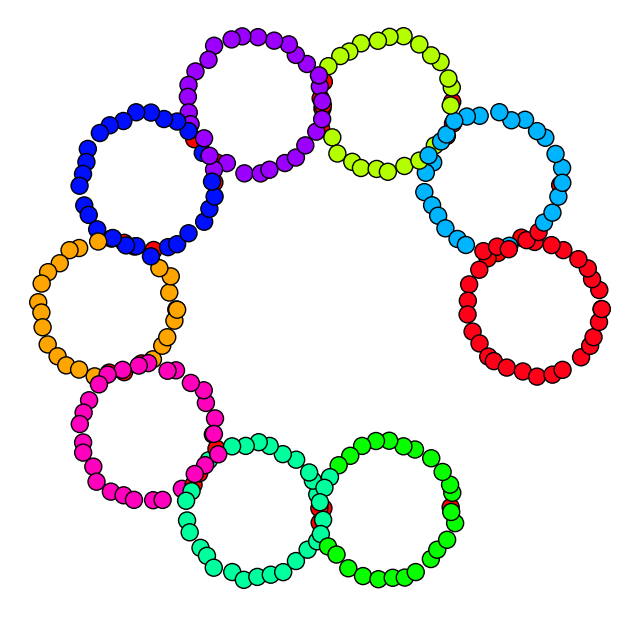

In [21]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(A[:,0],A[:,1], c = colour_source, s=150, edgecolors='black', vmax=9, vmin=0, cmap = cmap)
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/source_ex3.svg', dpi=300)
plt.show()

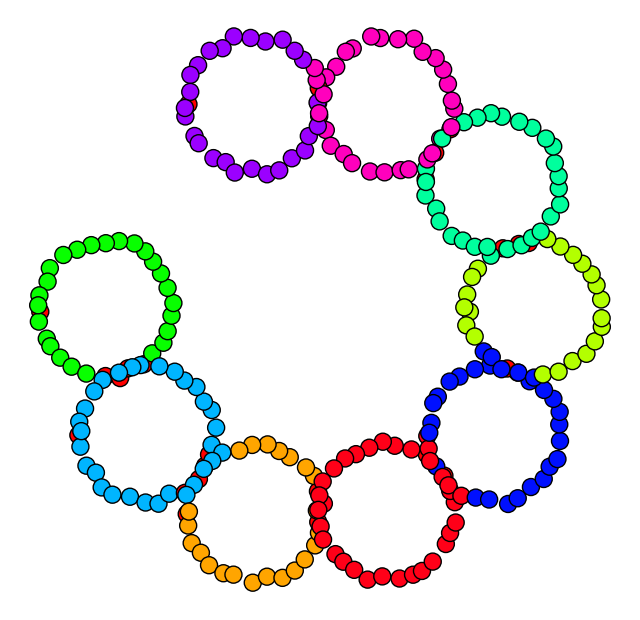

In [22]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(B[:,0],B[:,1],c = colour_pd, s=150,edgecolors='black', vmax=9, vmin=0, cmap = cmap)
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/targetpd_ex3.svg')
plt.show()

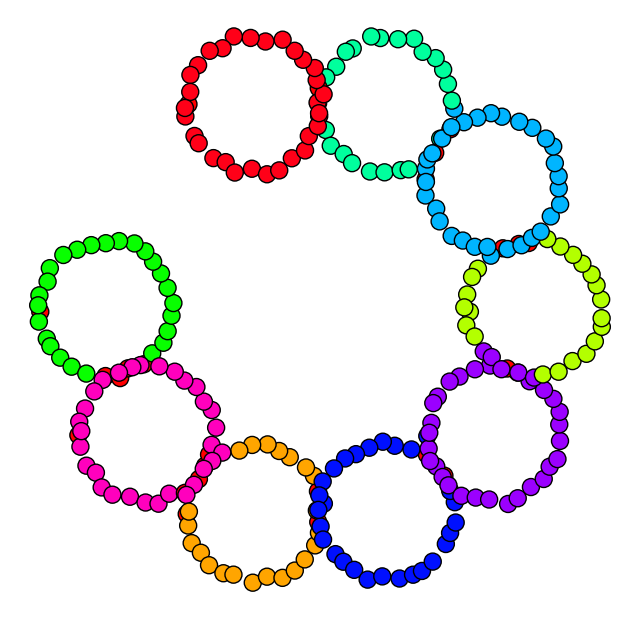

In [23]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(B[:,0],B[:,1],c = colour_tpot, s=150,edgecolors='black', vmax=9, vmin=0, cmap = cmap)
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/targettpot_ex3_alpha{}_beta{}.svg'.format(alpha,beta))
plt.show()